<a href="https://colab.research.google.com/github/isabellacadisco/I-hate-you-P7-/blob/main/tests/shap_test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install transformers datasets evaluate accelerate
%pip install optuna

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.3 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
dbutils.library.restartPython()

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
import evaluate
import numpy as np
from transformers import AutoModelForTokenClassification
import torch
from transformers import DataCollatorForTokenClassification
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import Trainer, TrainingArguments

In [ ]:
path_en = '/dbfs/mnt/tesi/hs/final_labels.csv'

data_en = load_dataset("csv", data_files=path_en)

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:45: UserWarning: The cache_dir for this dataset is /root/.cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/']
  warnings.warn(warning_message)
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:14: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
data_en = data_en.remove_columns(['entry_id', 'link_id', 'parent_id', 'entry_utc', 'subreddit', 'author', 'image', 'label_date', 'week', 'group', 'sheet_order', 'level_2', 'level_3', 'strength', 'highlight'])

In [ ]:
len(data_en['train'])

6567

train, validation, test split

In [ ]:
val_test = data_en.filter(lambda example: example['split'] == 'test').remove_columns(['split'])['train'].train_test_split(test_size=0.5, seed=42)

Filter:   0%|          | 0/6567 [00:00<?, ? examples/s]

In [ ]:
ds = DatasetDict({
    'train': data_en.filter(lambda example: example['split'] == 'train').remove_columns(['split'])['train'],
    'validation': val_test['train'],
    'test' : val_test['test']

})

Filter:   0%|          | 0/6567 [00:00<?, ? examples/s]

In [ ]:
ds = ds.rename_column("level_1", "label")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['body', 'label'],
        num_rows: 5264
    })
    validation: Dataset({
        features: ['body', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['body', 'label'],
        num_rows: 652
    })
})

In [ ]:
ds['train'][0]

{'body': 'Do you have the skin of a 80 year old grandma? Worry no more, just drink water!',
 'label': 'Nonmisogynistic'}

In [ ]:
def remove_none_rows(example):
    return example["body"] is not None

ds = ds.filter(remove_none_rows)

Filter:   0%|          | 0/5264 [00:00<?, ? examples/s]

Filter:   0%|          | 0/651 [00:00<?, ? examples/s]

Filter:   0%|          | 0/652 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['body', 'label'],
        num_rows: 5254
    })
    validation: Dataset({
        features: ['body', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['body', 'label'],
        num_rows: 650
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer(ds['train'][0]['body'])

{'input_ids': [101, 2079, 2017, 2031, 1996, 3096, 1997, 1037, 3770, 2095, 2214, 13055, 1029, 4737, 2053, 2062, 1010, 2074, 4392, 2300, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['body'], truncation=True, padding='max_length', max_length=512)

In [ ]:
tokenized = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/5254 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/650 [00:00<?, ? examples/s]

In [ ]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['body', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5254
    })
    validation: Dataset({
        features: ['body', 'label', 'input_ids', 'attention_mask'],
        num_rows: 651
    })
    test: Dataset({
        features: ['body', 'label', 'input_ids', 'attention_mask'],
        num_rows: 650
    })
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

print(accuracy.description)
print(f1.description)
print(precision.description)
print(recall.description)


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative


The F1 score is the harmonic mean of the precision and recall. It can be computed with the equation:
F1 = 2 * (precision * recall) / (precision + recall)


Precision is the fraction of correctly labeled positive examples out of all of the examples that were labeled as positive. It is computed via the equation:
Precision = TP / (TP + FP)
where TP is the True positives (i.e. the examples correctly labeled as positive) and FP is the False positive examples (i.e. the examples incorrectly labeled as positive).


Recall is the fraction of the positive examples that were correctly labeled by the model as positive. It can be computed with the equation:
Recall = TP / (TP + FN)
Where TP is the true positives and FN is the false negatives.



In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute metrics
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_value = f1.compute(predictions=predictions, references=labels)
    precision_value = precision.compute(predictions=predictions, references=labels)
    recall_value = recall.compute(predictions=predictions, references=labels)

    # Return metrics as a dictionary
    return {
        "accuracy": accuracy_value['accuracy'],
        "f1": f1_value['f1'],
        "precision": precision_value['precision'],
        "recall": recall_value['recall']
    }


In [ ]:
id2label = {0: "Nonmisogynistic", 1: "Misogynistic"}
label2id = {"Nonmisogynistic": 0, "Misogynistic": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
from transformers.utils import logging

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
logger = logging.get_logger(__name__)

In [ ]:
class Custom_EarlyStoppingCallback(EarlyStoppingCallback):

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        metric_to_check = args.metric_for_best_model
        if not metric_to_check.startswith("eval_"):
            metric_to_check = f"eval_{metric_to_check}"
        metric_value = metrics.get(metric_to_check)

        if metric_value is None:
            logger.warning(
                f"early stopping required metric_for_best_model, but did not find {metric_to_check} so early stopping"
                " is disabled"
            )
            return

        self.check_metric_value(args, state, control, metric_value)
        if self.early_stopping_patience_counter >= self.early_stopping_patience:
            print('EARLY STOPPING CALLED!')
            control.should_training_stop = True

In [ ]:
import copy
from copy import deepcopy

In [ ]:
def compute_objective_recall(metrics):
    """
    The default objective to maximize/minimize when doing an hyperparameter search. It is the evaluation loss if no
    metrics are provided to the [`Trainer`], the sum of all metrics otherwise.

    Args:
        metrics (`Dict[str, float]`): The metrics returned by the evaluate method.

    Return:
        `float`: The objective to minimize or maximize
    """
    metrics = copy.deepcopy(metrics)
    loss = metrics.pop("eval_loss", None)
    _ = metrics.pop("epoch", None)
    # Remove speed metrics
    speed_metrics = [
        m
        for m in metrics.keys()
        if m.endswith("_runtime") or m.endswith("_per_second") or m.endswith("_compilation_time")
    ]
    for sm in speed_metrics:
        _ = metrics.pop(sm, None)
    return loss if len(metrics) == 0 else metrics['eval_recall']

In [ ]:
# convert labels from string to 0,1
def convert_labels(example):
    example['label'] = label2id[example['label']]
    return example

converted_dataset_dict = tokenized.map(convert_labels)


Map:   0%|          | 0/5254 [00:00<?, ? examples/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/650 [00:00<?, ? examples/s]

In [ ]:
args_best = TrainingArguments(
    output_dir="/dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det/best_model",

    num_train_epochs=12,
    weight_decay = 0.01,
    learning_rate = 1.5e-5,

    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model = 'eval_recall', # bavoid FN
    load_best_model_at_end=True,
    push_to_hub=False,

    logging_first_step=True,
    fp16=True,
    auto_find_batch_size=True,
)


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer_best = Trainer(
    model=model,
    args=args_best,
    train_dataset=converted_dataset_dict['train'],
    eval_dataset=converted_dataset_dict['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks = [Custom_EarlyStoppingCallback(early_stopping_patience=2,
                                              early_stopping_threshold=0.01)]
)

In [ ]:
train_best_results = trainer_best.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())


EARLY STOPPING CALLED!


In [ ]:
trainer_best.evaluate()

EARLY STOPPING CALLED!


{'eval_loss': 0.39939579367637634,
 'eval_accuracy': 0.9247311827956989,
 'eval_f1': 0.5504587155963303,
 'eval_precision': 0.6818181818181818,
 'eval_recall': 0.46153846153846156,
 'eval_runtime': 4.0541,
 'eval_samples_per_second': 160.577,
 'eval_steps_per_second': 20.226,
 'epoch': 6.0}

In [ ]:
predictions = trainer_best.predict(converted_dataset_dict['test'])

In [ ]:
predicted_labels = np.argmax(predictions.predictions, axis=1)
ground_truth_labels = predictions.label_ids

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def print_confusion_matrix(predictions, labels):

    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-misogynistic", "Misogynistic"],
                yticklabels=["Non-misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


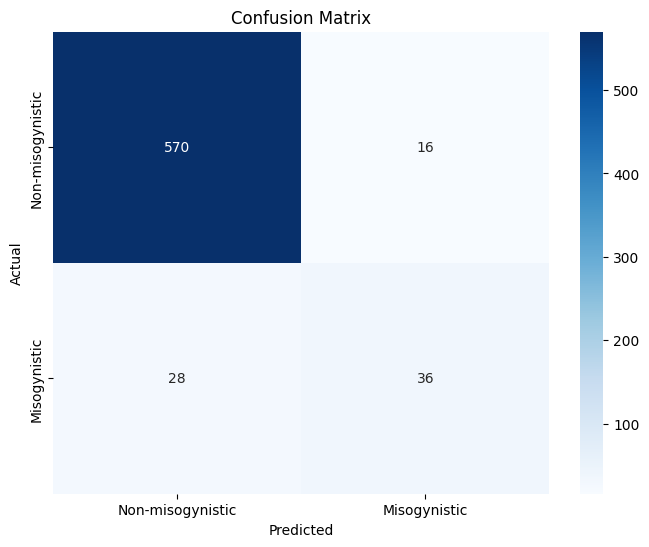

In [ ]:
print_confusion_matrix(predicted_labels, ground_truth_labels)

In [ ]:
def print_confusion_matrix_normalize(predictions, labels):

    cm = confusion_matrix(labels, predictions, normalize="true")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Non-misogynistic", "Misogynistic"],
                yticklabels=["Non-misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


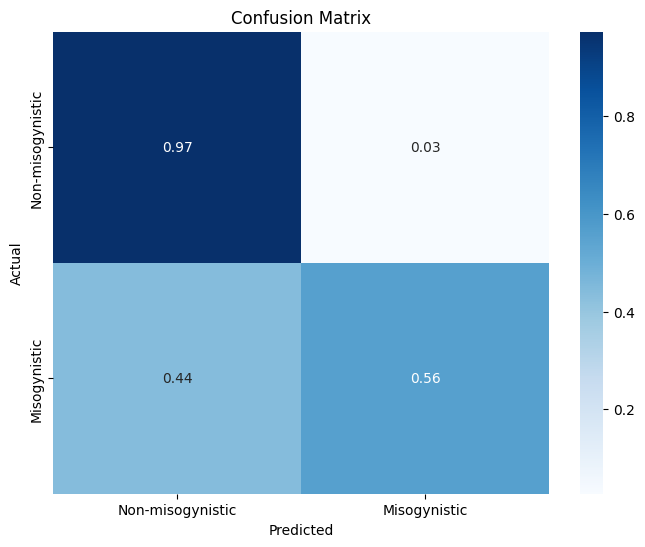

In [ ]:
print_confusion_matrix_normalize(predicted_labels, ground_truth_labels)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer_best.save_model('/dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det/best_model/model')

In [ ]:
best_model = AutoModelForSequenceClassification.from_pretrained('/dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det/best_model/model',
    id2label=id2label,
    label2id=label2id,).cuda()

In [ ]:
%pip install shap

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
import shap

In [ ]:
from transformers import pipeline

In [ ]:
# build a pipeline object to do predictions
pred = pipeline(
    "text-classification",
    model=best_model,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)

In [ ]:
explainer = shap.Explainer(pred)

In [ ]:
test_data = pd.DataFrame({'text': ds['test']['body'], 'label': ds['test']['label']})

In [ ]:
shap_values = explainer(test_data['text'][377])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 1278it [00:40, 23.73it/s]                          


In [ ]:
shap.plots.text(shap_values)

In [ ]:
shap_values_1 = explainer(tokenized['test'][377:378])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
shap.plots.text(shap_values_1)

In [ ]:
data_shap = ds['test']
data_shap

Dataset({
    features: ['body', 'label'],
    num_rows: 650
})

In [ ]:
data_shap = data_shap.rename_column("body", "text")

In [ ]:
shap_values_2 = explainer(data_shap[377:378])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
shap.plots.text(shap_values_2)

In [ ]:
shap.plots.text(shap_values_2[:, :, "Misogynistic"])

In [ ]:
shap_values_2

.values =
array([[[ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00040677, -0.00040677],
        [ 0.00045659, -0.00045659],
        [ 0.00045659, -0.00045659],
        [ 0.00045659, -0.00045659],
        [ 0.00045659, -0.00045659],
        [ 0.00045659, -0.00045659],
        [ 0.00045659, -0.00045659],
        [ 0.00045659, -0.00045659],
        [ 0.00049903, -0.00049903],
        [ 0.00049903, -0.00049903],
        [ 0.00049903, -0.00049903],
        [ 0.00049903, -0.00049903],
        [ 0.00049903, -0.00049903],
        [ 0.00049903, -0.00049903],
        [ 0.00049903, -0.00049903],
        [ 0.00049903, -0.00049903],
        [ 0.00055826, -0.00055826],
        [ 0.00055826, -0.00055826],
        [ 0.000558

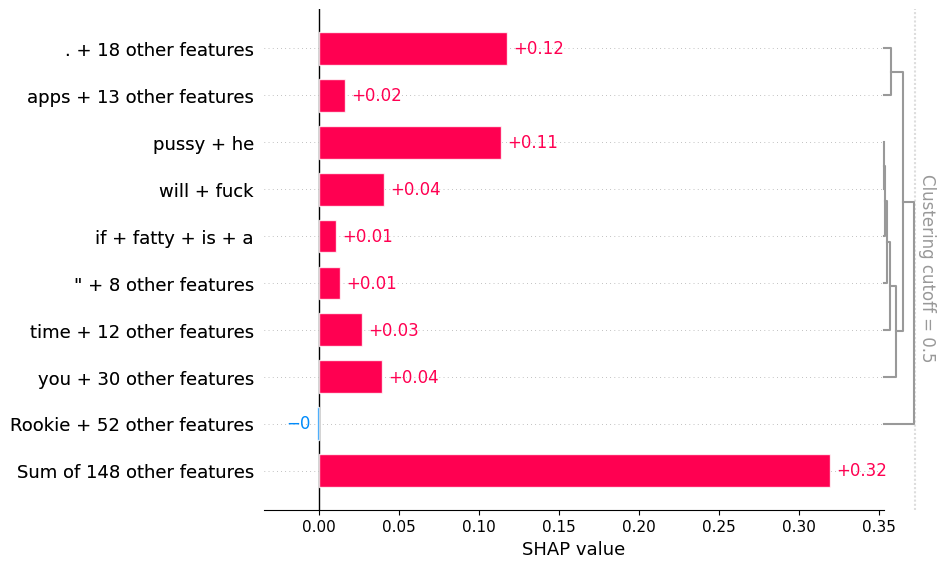

In [ ]:
shap.plots.bar(shap_values_2[0, :, "Misogynistic"])

In [ ]:
shap.plots.bar(shap_values_2[:, :, "Misogynistic"].mean(0))

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
File <command-2803712420586180>, line 1
----> 1 shap.plots.bar(shap_values_2[:, :, "Misogynistic"].mean(0))

File /databricks/python/lib/python3.10/site-packages/shap/plots/_bar.py:159, in bar(shap_values, max_display, order, clustering, clustering_cutoff, merge_cohorts, show_data, show)
    155 feature_order = np.argsort(np.mean([np.argsort(convert_ordering(order, Explanation(values[i]))) for i in range(values.shape[0])], 0))
    156 if partition_tree is not None:
    157 
    158     # compute the leaf order if we were to show (and so have the ordering respect) the whole partition tree
--> 159     clust_order = sort_inds(partition_tree, np.abs(values).mean(0))
    161     # now relax the requirement to match the partition tree ordering for connections above clustering_cutoff
    162     dist = scipy.spatial.distance.squareform(scipy.c

In [ ]:
data_shap[378]

{'text': 'Oh jeez Im so sorry that they assumed that. It really shows how a lack of information about something as simple as stress delaying periods can lead people to be like WOW YOU MUST BE PREgnanT HUH?\n\nNow that I think about it, my period was very late around the time I first started running, and it also tends to be late when Im having finals week panic attacks. Ah, the joys of being female',
 'label': 'Nonmisogynistic'}

In [ ]:
data_shap[377]

{'text': 'I would say you have three possible options. Rookie, intermediate, and advanced. Which option you choose is strictly up to your level of confidence. \n\nRookie: pick her up from work and when you see the guy, just give him a stare. Say nothing. Give him a handshake and crush his hand during the handshake. Say "is this the fat faggot you were telling me about?" This path is a little insecure but if fatty is a pussy he will fuck off\n\nIntermediate: Go thru her phone next time you see her. Search all apps, search her texts with keywords, social media. See if there\'s any communication between them. If there is, hard next the bitch. \n\nAdvanced: Tell her you don\'t care. Ignore the issue completely. Work on yourself, lift, talk to other girls. Make friends with other girls. Don\'t tell her about them but let her see that the cashier at the store finds you attractive. Subconsciously it will fuck with her big time. If she is chasing your validation she won\'t give a fuck about he

In [ ]:
data_shap

Dataset({
    features: ['text', 'label'],
    num_rows: 650
})

In [ ]:
shap_values_6 = explainer(data_shap[377:378])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
shap.plots.text(shap_values_6[:, :, "Misogynistic"])

In [ ]:
shap_values_3 = explainer(data_shap[377:379])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

No handler for 011e6066e8844af09ecaaa77fd460ac3


In [ ]:
shap.plots.text(shap_values_3[:, :, "Misogynistic"])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


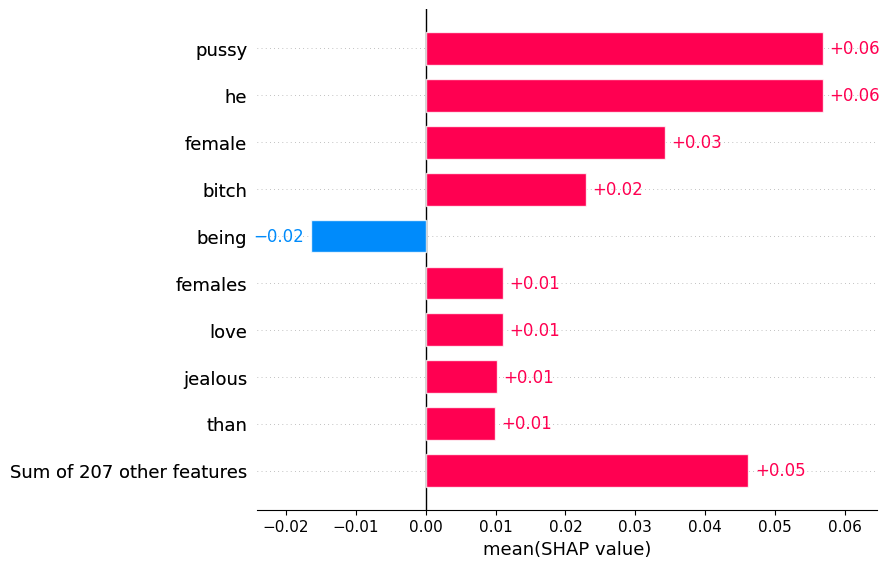

In [ ]:
shap.plots.bar(shap_values_3[:, :, "Misogynistic"].mean(0))

In [ ]:
mis_shap_data = data_shap.filter(lambda ex: ex['label'] == 'Misogynistic')

Filter:   0%|          | 0/650 [00:00<?, ? examples/s]

In [ ]:
mis_shap_data

Dataset({
    features: ['text', 'label'],
    num_rows: 64
})

In [ ]:
f(data_shap['text'])

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 56,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 108,
 109,
 110,
 111,
 112,
 113,
 115,
 116,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 157,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 173,
 174,
 175,
 176,
 178,
 180,
 181,
 182,
 183,
 184,
 185,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 211,
 212,

In [ ]:
shap_values_4 = explainer(mis_shap_data[:])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
File <command-2803712420586189>, line 1
----> 1 shap_values_4 = explainer(mis_shap_data[:])

File /databricks/python/lib/python3.10/site-packages/shap/explainers/_partition.py:125, in PartitionExplainer.__call__(self, max_evals, fixed_context, main_effects, error_bounds, batch_size, outputs, silent, *args)
    121 def __call__(self, *args, max_evals=500, fixed_context=None, main_effects=False, error_bounds=False, batch_size="auto",
    122              outputs=None, silent=False):
    123     """ Explain the output of the model on the given arguments.
    124     """
--> 125     return super().__call__(
    126         *args, max_evals=max_evals, fixed_context=fixed_context, main_effects=main_effects, error_bounds=error_bounds, batch_size=batch_size,
    127         outputs=outputs, silent=silent
    128     )

File /databricks/python/l

In [ ]:
def f(x):
    # Tokenize texts that are not too long
    tokenized_texts = [
        tokenizer.encode(v, max_length=512, truncation=True) if len(v) <= 512 else []
        for v in x
    ]

    # Filter out texts that are too long
    valid_indices = [i for i, tokens in enumerate(tokenized_texts) if tokens]
    return valid_indices

In [ ]:
valid_indices = f(mis_shap_data['text'])

In [ ]:
valid_indices

[0,
 2,
 3,
 4,
 5,
 7,
 9,
 10,
 13,
 14,
 15,
 16,
 17,
 19,
 23,
 24,
 27,
 29,
 31,
 32,
 33,
 37,
 38,
 39,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 54,
 57,
 58,
 59,
 60,
 62,
 63]

In [ ]:
shap_values_4 = explainer(mis_shap_data[valid_indices])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 41it [01:28,  2.47s/it]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


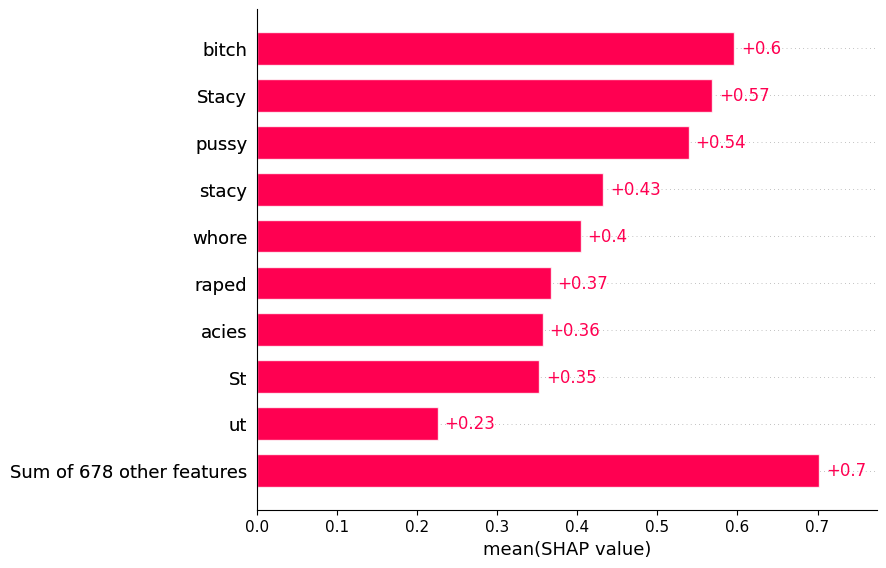

In [ ]:
shap.plots.bar(shap_values_4[:, :, "Misogynistic"].mean(0))

probabilmente avrebbe senso tutto lower case

In [ ]:
shap.plots.text(shap_values_4[:, :, "Misogynistic"])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


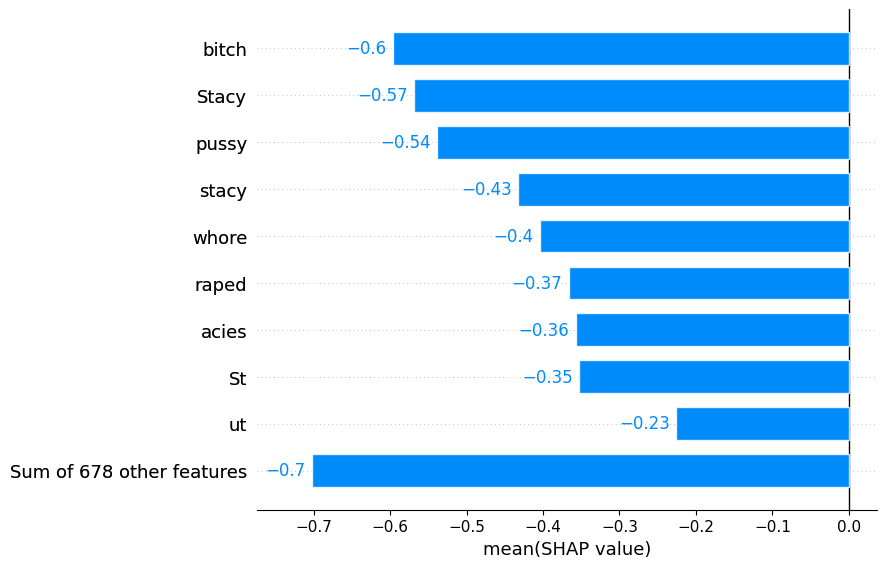

In [ ]:
shap.plots.bar(shap_values_4[:, :, "Nonmisogynistic"].mean(0))

In [ ]:
mis_shap_data['text']

['If I knew how to I would open my own subreddit called... Men boycotting woke women. Just to see how they respond to that!!!',
 'WHAT WOMEN WANT>"After 30 years of studying female psychology, I still haven\'t found an answer to the big question: What exactly do they want?" - Sigmund Freud\n\n&#x200B;\n\nThe more a woman corresponds to today\'s beauty criteria, the more she will turn to the man I will present in this writing. The requirements obviously vary according to their possibilities (physical, age, intellect), their education, background, personal experience.\n\n&#x200B;\n\n# WHAT WOMEN WANT: BIOLOGY\n\nWe start with 10 studies ([1](http://www.sscnet.ucla.edu/comm/haselton/unify_uploads/files/gildersleeve%20et%20al.%20sex%20roles%202013.pdf), [2](http://www.sscnet.ucla.edu/comm/haselton/unify_uploads/files/Larson%20et%20al.,%20in%20press%20hormones%20and%20behavior%202012.pdf), [3](http://www.sscnet.ucla.edu/comm/haselton/unify_uploads/files/larson%20pillsworth%20haselton%202012

In [ ]:
len(mis_shap_data['text'])

64

In [ ]:
for e in mis_shap_data['text']:
  print(len(e))

123
14036
266
67
90
344
1611
259
950
40
97
792
2299
200
493
258
208
107
6752
49
1277
765
1313
249
262
5224
716
153
738
373
14036
108
155
285
1277
729
615
109
161
133
2999
14036
738
258
32
150
182
109
155
695
11
153
89
4084
472
1260
3040
108
73
376
46
729
132
191


In [ ]:
mis_shap_data['text'][0]

'If I knew how to I would open my own subreddit called... Men boycotting woke women. Just to see how they respond to that!!!'